In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import wget
import zipfile
import pandas as pd
from numpy import genfromtxt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,GRU,Dropout,BatchNormalization,Input,Flatten,Bidirectional

In [2]:
#Downloading climate data set
#wget.download('https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip','jena_climate_2009_2016.csv.zip')

In [3]:
# unzipping climate data set
local_zip = 'jena_climate_2009_2016.csv.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('jena_climate_2009_2016')
zip_ref.close()


In [4]:
# Diplaying header
# f=open('G:\\courses_softwares\DeepLearning.AI-TensorFlow-Developer-Course\\sequence_modelling\jena_climate_2009_2016\\jena_climate_2009_2016.csv')
# data=f.read()
# f.close()
# data_lines=data.split('\n')
# data_lines[0]

In [5]:
#data_lines  

In [6]:
# Reading data as numpy array and removing hearder row and date column
# The data is recorded every 10 minutes
climate_df=my_data = genfromtxt('G:\\courses_softwares\DeepLearning.AI-TensorFlow-Developer-Course\\sequence_modelling\jena_climate_2009_2016\\jena_climate_2009_2016.csv', delimiter=',')
print('Shape:',climate_df   )
climate_df_nh=climate_df[1:100000,1:]

In [7]:
labels=climate_df_nh[:,1]
for i in range(0,climate_df_nh.shape[1]):
    climate_df_nh[:,i]=(climate_df_nh[:,i]-climate_df_nh[:,i].mean())/climate_df_nh[:,i].std()


(array([   450.,   2891.,  12538.,  54689.,  99220., 106023.,  91320.,
         41421.,  10464.,   1435.]),
 array([-3.85325486, -3.137534  , -2.42181313, -1.70609227, -0.9903714 ,
        -0.27465054,  0.44107033,  1.15679119,  1.87251206,  2.58823292,
         3.30395379]),
 <BarContainer object of 10 artists>)

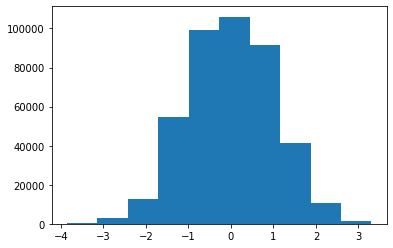

In [8]:
plt.hist(climate_df_nh[:,1])

Text(0.5, 0, 'T (degC)')

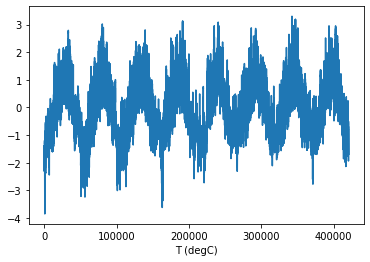

In [9]:
# Plotting T (degC)
plt.plot(climate_df_nh[:,1])
plt.gca().set_xlabel('Time')
plt.gca().set_xlabel('T (degC)')

Text(0.5, 1.0, 'First 10 day data')

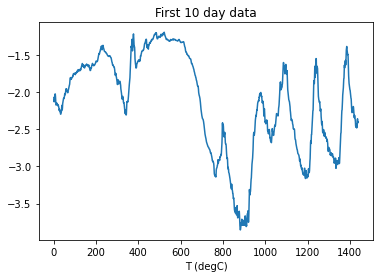

In [10]:
# Plotting T (degC) --- zoom
plt.plot(climate_df_nh[0:1440,1])
plt.gca().set_xlabel('Time')
plt.gca().set_xlabel('T (degC)')
plt.gca().set_title('First 10 day data')

In [11]:
# check number of rows in the dataframe
climate_df_nh.shape

(420451, 14)

In [12]:
# split data into train and val set
TRAIN_DATA_INDEX=int(100000*0.8)
train=climate_df_nh[0:,:TRAIN_DATA_INDEX]
val=climate_df_nh[TRAIN_DATA_INDEX:,:]

In [13]:
train.shape

(420451, 14)

In [14]:
lookback=720

In [15]:
# Define functions for dataset
def get_data(index):
    return train[index-lookback:index,:],[labels[1]]

def get_data_tf(index):
    series,label=tf.py_function(func=get_data,inp=[index], Tout=[tf.float32,tf.float32])  
    series.set_shape((lookback,14))
    label.set_shape([1])  
    return {'temperature_input':series},{'temperature_output':label}

In [16]:
# List all available devices
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12449476325838425883,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3127299278
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4359138115324273328
 physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"]

In [17]:
BATCH_SIZE=250  

In [18]:
# Define datasets - training and validation
with tf.device('/device:CPU:0'):
    training=tf.data.Dataset.from_tensor_slices(np.arange(lookback,TRAIN_DATA_INDEX-lookback)).map(get_data_tf).batch(BATCH_SIZE,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    validation=tf.data.Dataset.from_tensor_slices(np.arange(TRAIN_DATA_INDEX+lookback,-lookback)).map(get_data_tf).batch(BATCH_SIZE,drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [19]:
#next(iter(training))

In [20]:
strategy=tf.distribute.MirroredStrategy()

# Define a model
with strategy.scope():
    inpt=Input(shape=(720,14),name='temperature_input')
    x=Bidirectional(GRU(int(8),return_sequences=True,dropout=0.2, recurrent_dropout=0.2))(inpt)
    #x=GRU(int(16),return_sequences=False,dropout=0.2, recurrent_dropout=0.2)(inpt)
    x=Flatten()(x)
    x=Dense(1,name='temperature_output')(x)
    model=Model(inputs=inpt,outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='mean_squared_error',
                    metrics=['mean_absolute_percentage_error'])
    model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
temperature_input (InputLaye [(None, 720, 14)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 720, 16)           1152

In [21]:
with strategy.scope():
    model.fit(training,validation_data=validation,epochs=20)

Epoch 1/20
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
  9/669 [..............................] - ETA: 47:32 - loss: 22.1710 - mean_absolute_percentage_error: 185.8050